In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# 也許在前期 epoch 的時候，比如說某個使用者買了 A, B, C 課
# 我們可以假設另一個使用者買了 B, C 然後要模型產出一樣的結果
# 我們更可以假設另一個使用者買了 A 然後要模型要產出 B
# 我們更可以假設另一個使用者買了 A, B 然後要模型要產出 C

SELECT_CLASS_NUM = 50


In [155]:
course = pd.read_csv('../data/courses.csv')
data = pd.read_csv('../data/train.csv')
data.head(5)

,user_id,course_id
0,5bdecbfffec014002166796a,5f194354cad0d086f3ee24cf
1,5fedf958af850a915c86362c,5bfd47782d018e0020e4b0e4 5fc4a352d375951a03cc0...
2,5fd255c43136a460c6f3f930,598053e0acc137070007186a 6031136edd9bc1681035b892
3,5a0bde2aa15b3f001e98429a,5fc5ed671be929537e5283bb 5fc5edae001c9102feab8...
4,5fedf8132a0eb0bfab27882b,5e8e9d3c5a140c3d1e1c5245


In [156]:
id2cid = list(course['course_id'])
cid2id = {x: i  for i, x in enumerate(id2cid)}

counts = [0 for _ in range(len(id2cid))]
for i in range(len(data)):
    for x in data['course_id'][i].split(' '):
        counts[cid2id[x]] += 1
pivot = sorted(counts)[-SELECT_CLASS_NUM]
mask = [x >= pivot for x in counts]
print(sum(mask), 'classes is preserved, others are dropped.')

id2cid = [x for x, y in zip(id2cid, mask) if y]
cid2id = {x: i  for i, x in enumerate(id2cid)}

dropped = 0
for i in range(len(data)):
    tmp = []
    for x in data['course_id'][i].split(' '):
        if x in cid2id:
            tmp.append(cid2id[x])
        else:
            dropped += 1
    if not tmp:
        data['course_id'][i] = ['x']
    else:
        data['course_id'][i] = tmp
data = data.assign(course_taken = [len(x) for x in data['course_id']])
# data = data[data['course_taken'] != 0]
data.reset_index(drop=True, inplace=True)

print(data.head(5))
print('(courses x people)', sum(data['course_taken']), 'taken,', dropped, 'dropped')

50 classes is preserved, others are dropped.
                    user_id        course_id  course_taken
0  5bdecbfffec014002166796a              [x]             1
1  5fedf958af850a915c86362c  [8, 27, 41, 25]             4
2  5fd255c43136a460c6f3f930              [x]             1
3  5a0bde2aa15b3f001e98429a     [22, 21, 23]             3
4  5fedf8132a0eb0bfab27882b              [x]             1
(courses x people) 103018 taken, 53645 dropped


In [157]:

id2cid = [[i, x] for i, x in enumerate(id2cid)]
id2cid = pd.DataFrame(id2cid, columns=['index', 'course_id'])
id2cid.to_csv('id2cid.csv', index=False, columns=['index', 'course_id'])

In [158]:
# data.plot() # except 3 outlier, other people takes 60 classes at most
data.describe()

,course_taken
count,59737.000000
mean,1.724526
std,1.704611
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,21.000000


,number
count,50.000000
mean,1719.260000
std,1697.477238
min,517.000000
25%,699.000000
50%,1083.500000
75%,1531.750000
max,8582.000000


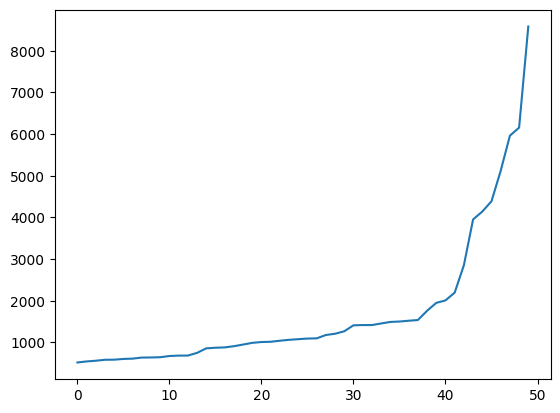

In [159]:
courses = [0 for _ in range(len(id2cid))]
for i in range(len(data)):
    for x in data['course_id'][i]:
        if x == 'x':
            break
        courses[x] += 1
plt.plot([i for i in range(len(courses))], sorted(courses))

if isinstance(courses, list):
    courses = [[x] for x in courses]
    courses = pd.DataFrame(courses, columns=['number'])
courses.describe()


In [160]:
preprocessed_data = data.copy()
for i in range(len(preprocessed_data)):
    preprocessed_data['course_id'][i] = ' '.join(str(x) for x in preprocessed_data['course_id'][i])
preprocessed_data.to_csv('train_preprocessed.csv', index=False, columns=['user_id', 'course_id'])
df = pd.read_csv('train_preprocessed.csv')
print(df.head(5))
print(df['course_id'][0].split(' '))

/tmp/ipykernel_977546/207657832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_data['course_id'][i] = ' '.join(str(x) for x in preprocessed_data['course_id'][i])


                    user_id   course_id
0  5bdecbfffec014002166796a           x
1  5fedf958af850a915c86362c  8 27 41 25
2  5fd255c43136a460c6f3f930           x
3  5a0bde2aa15b3f001e98429a    22 21 23
4  5fedf8132a0eb0bfab27882b           x
['x']


In [161]:
user = pd.read_csv('../data/users_preprocessed.csv', usecols=['user_id', 'gender', 'interests'])
train = pd.read_csv('train_preprocessed.csv', usecols=['user_id', 'course_id'])
user.head(5)

,user_id,gender,interests
0,54ccaa73a784960a00948687,0,26 7 39 28 3 5 6 31 4 21
1,54dca4456d7d350900e86bae,1,28 3 33 23 25 31 39 32 7 55 4
2,54e421bac5c9c00900cd8d47,0,3 14 4 6 20 11
3,54e961d4c5c9c00900cd8d84,2,2 8 5 43 36 18 55
4,54e9b744c5c9c00900cd8d8a,2,32 2 5 25 45 18


In [162]:
train.head(5)

,user_id,course_id
0,5bdecbfffec014002166796a,x
1,5fedf958af850a915c86362c,8 27 41 25
2,5fd255c43136a460c6f3f930,x
3,5a0bde2aa15b3f001e98429a,22 21 23
4,5fedf8132a0eb0bfab27882b,x


In [163]:
merged = pd.merge(train, user, on='user_id')
merged = merged.reindex(columns=['user_id', 'gender', 'interests', 'course_id'])
merged.head(5)
merged.to_csv('train_preprocessed.csv', index=False, columns=['user_id', 'gender', 'interests', 'course_id'])
df = pd.read_csv('train_preprocessed.csv')
df.head(5)

,user_id,gender,interests,course_id
0,5bdecbfffec014002166796a,0,26 3 7 4 62 8 27,x
1,5fedf958af850a915c86362c,0,2 38 52 1 8 9,8 27 41 25
2,5fd255c43136a460c6f3f930,1,57 10 2 1 34 20 11 22 5 15 14 18,x
3,5a0bde2aa15b3f001e98429a,0,41 6 47 79 3,22 21 23
4,5fedf8132a0eb0bfab27882b,1,37 43,x
